## Trading Strategy Post FOMC Meeting and Price Trend

In the previous strategy, the trades were entered and exited based on rolling sentiment score and price trend. In this notebook, you will learn to create and backtest a trading strategy where the trade's entry was based on the sentiment score and price trend after the entire FOMC report is released while the trade is held till the end of the day.


1. [Read the Data](#read)
2. [Trading Strategy](#tradingstrategy)
3. [Trade Level Analytics](#tradelevelanalytics)
4. [Performance Analysis](#performance)
5. [Conclusion and Next Steps](#conclusion)

## Import Libraries

In [1]:
# Import the 'datetime' module to work with date and time objects in Python
import datetime

# For data manipulation
import pandas as pd
import numpy as np

# Import utility functions 
import sys
sys.path.append('..')
from data_modules.trade_fed_utils import trade_analytics, update_signal_column, get_performance_metrics

# For data visualisation
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# To ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


<a id='read'></a>
## Read the Data

We have saved the FOMC sentiment score data in a CSV file named `daily_sentiment_score_FOMC_Transcript.csv`. You can read the file using the `read_csv()` method. 

In [2]:
# Import daily FOMC sentiment score data
daily_text = pd.read_csv(
    '../data_modules/daily_sentiment_score_FOMC_Transcript.csv', index_col=0)

# Print first 5 rows
daily_text.head()

,script,sentiment_score
timestamp,,
2022-01-26 19:36:00+00:00,"Good afternoon. At the Federal Reserve, we are...",0.071792
2022-03-16 18:36:00+00:00,Good afternoon. I w ant to begin by acknowledg...,0.021699
2022-05-04 18:36:00+00:00,Good afternoon. It’s nice to see everyone in p...,0.072392
2022-06-15 18:38:00+00:00,Good afternoon. I will begin with one overarch...,0.213533
2022-07-27 18:36:00+00:00,Good afternoon. My colleagues and I are strong...,0.092692


Import the minute data of SPY ETF with price trend information from the csv file `spy_ohlc_price_trend_jan22_to_jul24`.

In [3]:
# Read the CSV file containing OHLC data for SPY from Jan 2022 to Jul 2024 into a dataframe
minute_data = pd.read_csv('../data_modules/spy_ohlc_jan22_to_jul24.csv')

# Set the index of the dataframe to the 'timestamp' column after converting it to datetime format
minute_data.index = pd.to_datetime(minute_data.timestamp)

# Sort the dataframe by the index (timestamp) to ensure chronological order
minute_data = minute_data.sort_index()

# Calculate the 9-period moving average of the 'close' prices and store it in the 'mva9' column
minute_data['mva9'] = minute_data.close.rolling(window=9).mean()

# Calculate the 21-period moving average of the 'close' prices and store it in the 'mva21' column
minute_data['mva21'] = minute_data.close.rolling(window=21).mean()

# Drop any rows that contain NaN values (due to moving averages requiring a full window)
minute_data = minute_data.dropna()

# Display the first few rows of the dataframe to inspect the data
minute_data.head()

,timestamp,open,high,low,close,mva9,mva21
timestamp,,,,,,,
2022-01-26 00:20:00+00:00,2022-01-26 00:20:00+00:00,433.70,433.85,433.70,433.85,434.561111,434.650952
2022-01-26 00:21:00+00:00,2022-01-26 00:21:00+00:00,433.83,433.83,433.58,433.58,434.408889,434.576190
2022-01-26 00:22:00+00:00,2022-01-26 00:22:00+00:00,433.52,433.70,433.52,433.70,434.265556,434.523810
2022-01-26 00:23:00+00:00,2022-01-26 00:23:00+00:00,433.68,433.90,433.68,433.76,434.127778,434.466667
2022-01-26 00:24:00+00:00,2022-01-26 00:24:00+00:00,433.73,433.83,433.55,433.67,433.971111,434.419524


In [4]:
# Read the CSV file containing minute-level OHLC price trend data for SPY from Jan 2022 to Jul 2024
# The first column (index_col=0) is set as the index of the dataframe
minute_data = pd.read_csv(
    '../data_modules/spy_ohlc_price_trend_jan22_to_jul24.csv', index_col=0)

minute_data.index = pd.to_datetime(minute_data.index)

# Display the first few rows of the dataframe to inspect the data
minute_data.head()

,open,high,low,close,mva9,mva21
timestamp,,,,,,
2022-01-26 00:20:00+00:00,433.70,433.85,433.70,433.85,434.561111,434.650952
2022-01-26 00:21:00+00:00,433.83,433.83,433.58,433.58,434.408889,434.576190
2022-01-26 00:22:00+00:00,433.52,433.70,433.52,433.70,434.265556,434.523810
2022-01-26 00:23:00+00:00,433.68,433.90,433.68,433.76,434.127778,434.466667
2022-01-26 00:24:00+00:00,433.73,433.83,433.55,433.67,433.971111,434.419524


<a id='tradingstrategy'></a>
## Trading Strategy

A long position is taken when the following conditions are met

* The sentiment score of the FOMC report is more than the sentiment score threshold of 0.1.
* The shorter moving average is more than the longer moving average (mva9 > mva21).

Similarly, a short position is taken when 

* The sentiment score of the FOMC report is less than the sentiment score threshold of -0.1.
* The longer moving average is more than the shorter moving average.

The trades are closed at the end of the day.

Create a dataframe `trade_sheet` to store all trade-related data. Initialise the `current_position` variable to track whether a trade is open (1 for a long position) or closed (0 for no position). Define variables to store key trade information, including `entry_datetime`, `entry_price`, `exit_datetime`, and `exit_price`, which will be populated as trades are executed. Additionally, set the `sentiment_score_threshold` to 0.1 to trigger entering or exiting trades based on sentiment analysis.

In [5]:
# Create a dataframe 'trade_sheet' to store the trades
trade_sheet = pd.DataFrame()

# Initialise the current_position as '0'
current_position = 0

# Define a variable to store the long entry date
entry_datetime = ''

# Define a variable to store the long entry price
entry_price = ''

# Define a variable to store the long exit date
exit_datetime = ''

# Define a variable to store the long exit price
exit_price = ''

sentiment_score_threshold = 0.1 # Strategy-1: Enter long / short when rolling sentiment score crosses a threshold

# Iterate over the dates in the dataframe 'data'
for i in daily_text.index:

    if (daily_text.loc[i]['sentiment_score']
            > 0) and (minute_data.loc[i].mva9
                                              > minute_data.loc[i].mva21):
        print('__________')
        print('opening long position')
        print(i)
        current_position = 1
        # Define the variable 'entry_date'
        entry_datetime = i
        entry_price = minute_data.loc[i].close
        exit_datetime = minute_data.loc[str(i)[:10]][-2:-1].index[0]
        exit_price = minute_data.loc[str(i)[:10]][-2:-1].close[0]
        print(exit_datetime)

        # Append the details of this trade to the 'trade_sheet' dataframe
        trade_sheet = trade_sheet.append(
            [(current_position, entry_datetime, entry_price, exit_datetime,
              exit_price)],
            ignore_index=True)

    elif (daily_text.loc[i]['sentiment_score']
          < 0) and (minute_data.loc[i].mva9
                                             < minute_data.loc[i].mva21):
        print('__________')
        print('opening short position')
        current_position = -1
        # Define the variable 'entry_date'
        entry_datetime = i
        entry_price = minute_data.loc[i].close
        exit_datetime = minute_data.loc[str(i)[:10]][-2:-1].index[0]
        exit_price = minute_data.loc[str(i)[:10]][-2:-1].close[0]

        # Append the details of this trade to the 'trade_sheet' dataframe
        trade_sheet = trade_sheet.append(
            [(current_position, entry_datetime, entry_price, exit_datetime,
              exit_price)],
            ignore_index=True)

# Define the names of columns in 'trade_sheet' dataframe
trade_sheet.columns = [
    'Position', 'Entry Datetime', 'Entry Price', 'Exit Datetime', 'Exit Price'
]

# Calculate the profit and loss (PnL) for each trade in the 'trade_sheet'
# PnL is calculated by multiplying the 'Position' (number of units traded) by the difference between the 'Exit Price' and the 'Entry Price'
trade_sheet['pnl'] = trade_sheet['Position'] * (trade_sheet['Exit Price'] -
                                                trade_sheet['Entry Price'])

# Display the last few rows of the 'trade_sheet' to review the PnL calculations
trade_sheet.tail()

__________
opening long position
2022-01-26 19:36:00+00:00
2022-01-26 23:58:00+00:00
__________
opening long position
2022-07-27 18:36:00+00:00
2022-07-27 23:58:00+00:00
__________
opening long position
2022-09-21 18:37:00+00:00
2022-09-21 23:58:00+00:00
__________
opening long position
2022-11-02 18:36:00+00:00
2022-11-02 23:58:00+00:00
__________
opening long position
2023-06-14 18:34:00+00:00
2023-06-14 23:58:00+00:00
__________
opening long position
2023-12-13 19:37:00+00:00
2023-12-13 23:58:00+00:00
__________
opening long position
2024-01-31 19:35:00+00:00
2024-01-31 23:55:00+00:00
__________
opening long position
2024-05-01 18:36:00+00:00
2024-05-01 23:58:00+00:00
__________
opening long position
2024-06-12 18:37:00+00:00
2024-06-12 23:58:00+00:00
__________
opening long position
2024-07-31 18:35:00+00:00
2024-07-31 23:58:00+00:00


,Position,Entry Datetime,Entry Price,Exit Datetime,Exit Price,pnl
5,1,2023-12-13 19:37:00+00:00,468.29,2023-12-13 23:58:00+00:00,470.46,2.17
6,1,2024-01-31 19:35:00+00:00,486.73,2024-01-31 23:55:00+00:00,483.74,-2.99
7,1,2024-05-01 18:36:00+00:00,502.81,2024-05-01 23:58:00+00:00,502.32,-0.49
8,1,2024-06-12 18:37:00+00:00,542.52,2024-06-12 23:58:00+00:00,542.18,-0.34
9,1,2024-07-31 18:35:00+00:00,550.89,2024-07-31 23:58:00+00:00,553.40,2.51


<a id='tradelevelanalytics'></a>

## Trade Level Analytics

Generate performance analytics for a trading strategy using the `trade_analytics` function to calculate various trade level statistics. Save the output dataframe with trade level analytics in the `trade_level_analytics` dataframe.

In [6]:
# Perform trade analytics on the 'trade_sheet' dataframe using the function 'trade_analytics' to compute various trade level analytics
trade_level_analytics = trade_analytics(trade_sheet) 

# Display the results of the trade-level analytics to review performance metrics
trade_level_analytics

,Strategy
Total pnl,-15.91
total_trades,10
Number of Winners,4
Number of Losers,6
Win (%),40.0
Loss (%),60.0
per_trade_pnl_winners,2.45
per_trade_pnl_losers,4.28
Average holding time,0 days 05:03:48


### Update Trading Signals in DataFrame

Similar to the previous notebook, update the signal column in the `minute_data` dataframe using the function `update_signal_column`.

In [7]:
# Initiate the 'signal' column
minute_data['signal'] = 0

# Update the 'minute_data' DataFrame by applying the 'update_signal_column' function
minute_data = update_signal_column(trade_sheet, minute_data)

# Display the first few rows of the updated 'minute_data' to verify the signal column update
minute_data.head()

,open,high,low,close,mva9,mva21,signal
timestamp,,,,,,,
2022-01-26 00:20:00+00:00,433.70,433.85,433.70,433.85,434.561111,434.650952,0
2022-01-26 00:21:00+00:00,433.83,433.83,433.58,433.58,434.408889,434.576190,0
2022-01-26 00:22:00+00:00,433.52,433.70,433.52,433.70,434.265556,434.523810,0
2022-01-26 00:23:00+00:00,433.68,433.90,433.68,433.76,434.127778,434.466667,0
2022-01-26 00:24:00+00:00,433.73,433.83,433.55,433.67,433.971111,434.419524,0


<a id='performance'></a>
## Performance Analysis

Use the function `get_performance_metrics` to calculate the performance measures and analyse the strategy.

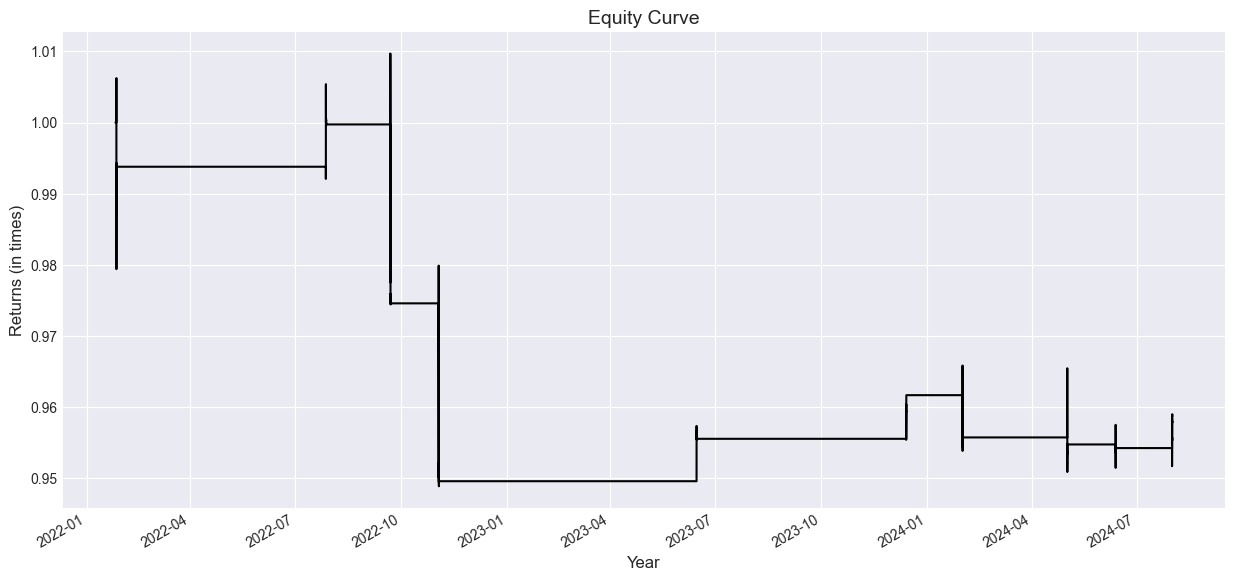

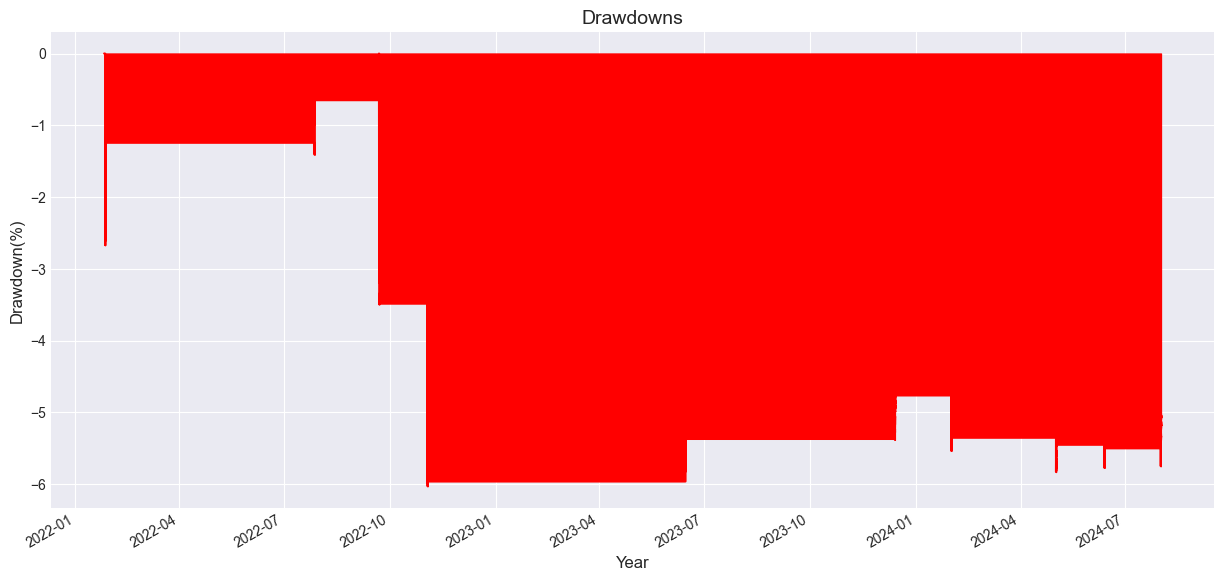

                 Strategy
Sharpe Ratio        -4.75
Maximum Drawdown   -6.03%


In [8]:
# Call the function
get_performance_metrics(minute_data.dropna())

The strategy using the sentiment score of the FOMC report along with the price trend generated a Sharpe ratio of -4.75 with a maximum drawdown of 6.03%. It can be observed that there is no improvement in the performance 
<a id='conclusion'></a>

## Conclusion and Next Steps
In this notebook, you tested the variation of a trading strategy based on the sentiment score of the entire FOMC report and the price trend. It is observed that taking positions after the end of the FOMC meeting and holding till EOD didn't improve the strategy. In the upcoming notebook, we will explore the variations of this strategy by not considering the price trend and just take trades based on the sentiment of the FOMC meeting at the end of the meeting and hold the positions till EOD and study the performance. <br><br>